In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd

from utils.train_evaluate import Trainer
from models.TextRNN_att import TextRNN_att
from data_ag_news.data_process.data_process_glove import DataProcess

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dp = DataProcess('../datasets/train.jsonl', '../datasets/test.jsonl', device, 128)
train_loader, test_loader = dp.get_dataLoader(141)
pre_vector = dp.get_pre_trained("../../extra/glove_vector/glove.6B.50d.txt")
print(pre_vector.shape)

torch.Size([95812, 50])


### Attention部分计算公式(类似加性注意力)

$$
\begin{aligned}
u_{i t} &=\tanh \left(W_{w} h_{i t}+b_{w}\right) \\
\alpha_{i t} &=\frac{\exp \left(u_{i t}^{\top} u_{w}\right)}{\sum_{t} \exp \left(u_{i t}^{\top} u_{w}\right)} \\
s_{i} &=\sum_{t} \alpha_{i t} h_{i t}
\end{aligned}
$$

In [5]:
model = TextRNN_att(num_class=4, vocab_size=pre_vector.shape[0], embedding_size=pre_vector.shape[1],
                    hidden_size=256, num_layers=2, dropout_ratio=0.3, bidirectional=True)
# 使用模型预训练词向量矩阵
model.embed.weight.data.copy_(pre_vector)
model.embed.weight.requires_grad = False  # 冻结网络层,使之不参与训练
model = model.to(device)

epochs = 20
lr = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [6]:
def compute_metrics_f1(predict_all, y_true):
    """f1 score评估函数"""
    predict = predict_all.argmax(-1)
    label = y_true
    acc = f1_score(label, predict, average='micro')
    return {"f1": acc}


t_and_v = Trainer(model=model, optimizer=optimizer, criterion=criterion, epochs=epochs)

metric_result = t_and_v.train(train_loader=train_loader, valid_loader=test_loader,
                              compute_metrics=compute_metrics_f1, verbose=100)
metric_result_df = pd.DataFrame(metric_result)
metric_result_df.index.name = 'epoch'
metric_result_df

Train Epoch: 0  [0    /120000 (0  %)]	Loss: 1.387203	f1: 0.250000
Train Epoch: 0  [12800/120000 (11 %)]	Loss: 1.381306	f1: 0.421875
Train Epoch: 0  [25600/120000 (21 %)]	Loss: 1.376260	f1: 0.507812
Train Epoch: 0  [38400/120000 (32 %)]	Loss: 1.369464	f1: 0.656250
Train Epoch: 0  [51200/120000 (43 %)]	Loss: 1.363970	f1: 0.703125
Train Epoch: 0  [64000/120000 (53 %)]	Loss: 1.356849	f1: 0.679688
Train Epoch: 0  [76800/120000 (64 %)]	Loss: 1.340326	f1: 0.773438
Train Epoch: 0  [89600/120000 (75 %)]	Loss: 1.334272	f1: 0.781250
Train Epoch: 0  [102400/120000 (85 %)]	Loss: 1.323321	f1: 0.750000
Train Epoch: 0  [115200/120000 (96 %)]	Loss: 1.299183	f1: 0.757812
Train Epoch: 0  [120000/120000 (100%)]	Loss: 1.305349	f1: 0.687500
----------------------------------------------------------------------------------------------------
Train Epoch: 1  [0    /120000 (0  %)]	Loss: 1.305735	f1: 0.703125
Train Epoch: 1  [12800/120000 (11 %)]	Loss: 1.275157	f1: 0.812500
Train Epoch: 1  [25600/120000 (21 %)]	

,Training loss,Training f1,Validation loss,Validation f1
epoch,,,,
0,1.301557,0.709517,1.302508,0.707500
1,0.824514,0.797642,0.828534,0.792368
2,0.536022,0.826200,0.542577,0.820263
3,0.453527,0.844275,0.461137,0.840526
4,0.425330,0.856033,0.436502,0.846579
5,0.403158,0.862900,0.414992,0.856579
6,0.404363,0.860917,0.415029,0.856184
7,0.394791,0.868350,0.403062,0.862763
8,0.379358,0.873667,0.390336,0.871316


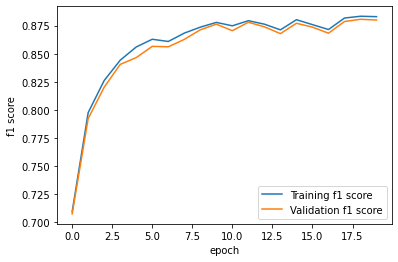

In [7]:
plt.plot(metric_result['Training f1'], label='Training f1 score')
plt.plot(metric_result['Validation f1'], label='Validation f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend()
plt.show()